# Face Mask Detection

### read the data

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# add kaggle api permissions
!pip install kaggle

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
#download and extract the dataset
!kaggle datasets download -d andrewmvd/face-mask-detection
!unzip face-mask-detection.zip


100% 396M/398M [00:01<00:00, 295MB/s]
100% 398M/398M [00:01<00:00, 241MB/s]
Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  i

In [4]:

import os
from scipy.spatial import distance
import cv2
import pickle
import math
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime
import xml.etree.ElementTree as ET
import xgboost as xgb
from sklearn.metrics import precision_score
from itertools import product
import statistics
from sklearn.metrics import confusion_matrix



In [5]:
annot_path = "/content/annotations"
imgs_path = "/content/images"

In [6]:
import glob
import xml.etree.ElementTree as ET
import pandas as pd

# Initialize the dataset dictionary
dataset = {
    "file": [],
    "label": [],
    "width": [],
    "height": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
}

# Loop through each XML annotation file
for anno in glob.glob(annot_path + "/*.xml"):
    tree = ET.parse(anno)
    root = tree.getroot()

    # Extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)

    # Iterate over each object in the XML
    for obj in root.findall('.//object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(round(float(bbox.find('xmin').text)))
        ymin = int(round(float(bbox.find('ymin').text)))
        xmax = int(round(float(bbox.find('xmax').text)))
        ymax = int(round(float(bbox.find('ymax').text)))

        # Append the data to the dataset dictionary
        dataset['file'].append(anno.split('/')[-1][:-4])
        dataset['label'].append(name)
        dataset['width'].append(width)
        dataset['height'].append(height)
        dataset['xmin'].append(xmin)
        dataset['ymin'].append(ymin)
        dataset['xmax'].append(xmax)
        dataset['ymax'].append(ymax)

# Convert the dataset dictionary to a DataFrame
df = pd.DataFrame(dataset)
df


,file,label,width,height,xmin,ymin,xmax,ymax
0,maksssksksss120,with_mask,301,400,59,185,183,336
1,maksssksksss512,with_mask,400,280,19,46,40,69
2,maksssksksss512,with_mask,400,280,82,40,99,61
3,maksssksksss512,with_mask,400,280,98,26,132,64
4,maksssksksss512,with_mask,400,280,172,41,198,70
...,...,...,...,...,...,...,...,...
4067,maksssksksss216,with_mask,400,300,8,64,43,93
4068,maksssksksss216,with_mask,400,300,225,44,261,93
4069,maksssksksss216,with_mask,400,300,208,52,225,77
4070,maksssksksss216,with_mask,400,300,328,48,348,66


In [7]:
# Add Image and Annotation File Names
df['annotation_file'] = df['file'] + '.xml'
df['image_file'] = df['file'] + '.png'


In [8]:
df

,file,label,width,height,xmin,ymin,xmax,ymax,annotation_file,image_file
0,maksssksksss120,with_mask,301,400,59,185,183,336,maksssksksss120.xml,maksssksksss120.png
1,maksssksksss512,with_mask,400,280,19,46,40,69,maksssksksss512.xml,maksssksksss512.png
2,maksssksksss512,with_mask,400,280,82,40,99,61,maksssksksss512.xml,maksssksksss512.png
3,maksssksksss512,with_mask,400,280,98,26,132,64,maksssksksss512.xml,maksssksksss512.png
4,maksssksksss512,with_mask,400,280,172,41,198,70,maksssksksss512.xml,maksssksksss512.png
...,...,...,...,...,...,...,...,...,...,...
4067,maksssksksss216,with_mask,400,300,8,64,43,93,maksssksksss216.xml,maksssksksss216.png
4068,maksssksksss216,with_mask,400,300,225,44,261,93,maksssksksss216.xml,maksssksksss216.png
4069,maksssksksss216,with_mask,400,300,208,52,225,77,maksssksksss216.xml,maksssksksss216.png
4070,maksssksksss216,with_mask,400,300,328,48,348,66,maksssksksss216.xml,maksssksksss216.png


In [9]:
import cv2
import matplotlib.pyplot as plt

def draw_image_bboxes(image_path, annotations_df):
    # Read and convert the image
    img = cv2.imread(image_path)
    img_name = image_path.split('/')[-1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Initialize an empty list for bounding boxes
    boxes = []

    # Iterate through the relevant rows in the DataFrame
    for idx in annotations_df[annotations_df['image_file'] == img_name].index:
        bbox_coords = annotations_df.loc[idx, ['xmin', 'ymin', 'xmax', 'ymax']]
        x, y, xmax, ymax = bbox_coords
        width, height = xmax - x, ymax - y
        boxes.append((x, y, width, height))

        # Determine the label and color
        label = annotations_df.loc[idx, 'label']
        if label == 'with_mask':
            color = (0, 200, 0)
            text = "Mask"
        elif label == 'mask_incorrectly_worn':
            color = (255, 255, 0)
            text = 'Incorrect'
        else:
            color = (200, 0, 0)
            text = 'No mask'

        # Draw rectangle and text
        cv2.rectangle(img, (x, y), (x + width, y + height), color, 2)
        cv2.putText(img, text, (x - 8, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color)

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

    return boxes, img


In [10]:
directory = 'cropped_images'
parent_directory = '/content'
path = os.path.join(parent_directory, directory)
os.mkdir(path)

In [11]:
df['cropped_image_file'] = df['file']
df

,file,label,width,height,xmin,ymin,xmax,ymax,annotation_file,image_file,cropped_image_file
0,maksssksksss120,with_mask,301,400,59,185,183,336,maksssksksss120.xml,maksssksksss120.png,maksssksksss120
1,maksssksksss512,with_mask,400,280,19,46,40,69,maksssksksss512.xml,maksssksksss512.png,maksssksksss512
2,maksssksksss512,with_mask,400,280,82,40,99,61,maksssksksss512.xml,maksssksksss512.png,maksssksksss512
3,maksssksksss512,with_mask,400,280,98,26,132,64,maksssksksss512.xml,maksssksksss512.png,maksssksksss512
4,maksssksksss512,with_mask,400,280,172,41,198,70,maksssksksss512.xml,maksssksksss512.png,maksssksksss512
...,...,...,...,...,...,...,...,...,...,...,...
4067,maksssksksss216,with_mask,400,300,8,64,43,93,maksssksksss216.xml,maksssksksss216.png,maksssksksss216
4068,maksssksksss216,with_mask,400,300,225,44,261,93,maksssksksss216.xml,maksssksksss216.png,maksssksksss216
4069,maksssksksss216,with_mask,400,300,208,52,225,77,maksssksksss216.xml,maksssksksss216.png,maksssksksss216
4070,maksssksksss216,with_mask,400,300,328,48,348,66,maksssksksss216.xml,maksssksksss216.png,maksssksksss216


In [12]:
import os
import cv2

def crop_and_save_images(df, source_path, dest_path='./cropped_images'):
    for idx, row in df.iterrows():
        # Constructing file paths
        img_path = os.path.join(source_path, row['image_file'])
        img = cv2.imread(img_path)

        # Generating new file name for cropped image
        new_filename = f"{row['cropped_image_file']}-{idx}.png"
        df.at[idx, 'cropped_image_file'] = new_filename

        # Cropping the image based on bounding box coordinates
        bbox = row[['xmin', 'ymin', 'xmax', 'ymax']]
        cropped_img = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]

        # Saving the cropped image
        save_path = os.path.join(dest_path, new_filename)
        cv2.imwrite(save_path, cropped_img)

# Usage
crop_and_save_images(df, imgs_path)


In [13]:
df

,file,label,width,height,xmin,ymin,xmax,ymax,annotation_file,image_file,cropped_image_file
0,maksssksksss120,with_mask,301,400,59,185,183,336,maksssksksss120.xml,maksssksksss120.png,maksssksksss120-0.png
1,maksssksksss512,with_mask,400,280,19,46,40,69,maksssksksss512.xml,maksssksksss512.png,maksssksksss512-1.png
2,maksssksksss512,with_mask,400,280,82,40,99,61,maksssksksss512.xml,maksssksksss512.png,maksssksksss512-2.png
3,maksssksksss512,with_mask,400,280,98,26,132,64,maksssksksss512.xml,maksssksksss512.png,maksssksksss512-3.png
4,maksssksksss512,with_mask,400,280,172,41,198,70,maksssksksss512.xml,maksssksksss512.png,maksssksksss512-4.png
...,...,...,...,...,...,...,...,...,...,...,...
4067,maksssksksss216,with_mask,400,300,8,64,43,93,maksssksksss216.xml,maksssksksss216.png,maksssksksss216-4067.png
4068,maksssksksss216,with_mask,400,300,225,44,261,93,maksssksksss216.xml,maksssksksss216.png,maksssksksss216-4068.png
4069,maksssksksss216,with_mask,400,300,208,52,225,77,maksssksksss216.xml,maksssksksss216.png,maksssksksss216-4069.png
4070,maksssksksss216,with_mask,400,300,328,48,348,66,maksssksksss216.xml,maksssksksss216.png,maksssksksss216-4070.png


In [14]:
classes=df['label'].unique()
labels=df['label']
df.drop(['label'],axis=1,inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_temp, Y_train, Y_temp = train_test_split(df, labels, test_size=0.25, stratify=labels, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.4, stratify=Y_temp, random_state=42)


In [16]:
image_target_size = (int(60), int(60))

In [17]:
X_train['label']=Y_train
X_test['label']=Y_test
X_val['label']=Y_val


In [18]:
X_train

,file,width,height,xmin,ymin,xmax,ymax,annotation_file,image_file,cropped_image_file,label
2646,maksssksksss282,400,267,175,55,215,93,maksssksksss282.xml,maksssksksss282.png,maksssksksss282-2646.png,with_mask
3570,maksssksksss577,400,267,188,55,203,72,maksssksksss577.xml,maksssksksss577.png,maksssksksss577-3570.png,with_mask
309,maksssksksss314,400,267,1,33,38,89,maksssksksss314.xml,maksssksksss314.png,maksssksksss314-309.png,with_mask
3128,maksssksksss325,400,267,102,147,112,158,maksssksksss325.xml,maksssksksss325.png,maksssksksss325-3128.png,with_mask
969,maksssksksss376,400,221,58,48,94,88,maksssksksss376.xml,maksssksksss376.png,maksssksksss376-969.png,with_mask
...,...,...,...,...,...,...,...,...,...,...,...
657,maksssksksss158,400,278,323,82,342,101,maksssksksss158.xml,maksssksksss158.png,maksssksksss158-657.png,with_mask
3576,maksssksksss577,400,267,74,64,83,75,maksssksksss577.xml,maksssksksss577.png,maksssksksss577-3576.png,with_mask
316,maksssksksss314,400,267,251,137,272,156,maksssksksss314.xml,maksssksksss314.png,maksssksksss314-316.png,with_mask
1579,maksssksksss296,400,226,172,46,184,65,maksssksksss296.xml,maksssksksss296.png,maksssksksss296-1579.png,with_mask


### Training the model



In [97]:
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense

In [98]:
train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 64,
    seed = 42,
    class_mode = 'categorical',
    target_size = image_target_size
)

val_image_generator = ImageDataGenerator(rescale = 1. / 255.)
val_generator = val_image_generator.flow_from_dataframe(
    dataframe = X_val,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,  # Shuffle the validation set if desired
    class_mode = 'categorical',
    target_size = image_target_size
)


test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 3054 validated image filenames belonging to 3 classes.
Found 610 validated image filenames belonging to 3 classes.
Found 408 validated image filenames belonging to 3 classes.


In [133]:
def make_model():
    # Load the VGG19 model
    base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(60, 60, 3))

    # Freeze the layers of the VGG19 model
    for layer in base_vgg19.layers:
        layer.trainable = False

    # Create a new Sequential model
    model = Sequential()

    # Add the base VGG19 model
    model.add(base_vgg19)

    # Add a Flatten layer
    model.add(Flatten())

    # Add a Dense layer, reducing the number of features (e.g., to 512)
    model.add(Dense(512, activation='relu'))  # This layer helps in reducing feature dimensions

    # Final Dense layer for classification
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes
    return model



# Display the model summary
model = make_model()
model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_19 (Flatten)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [134]:
from keras.metrics import Precision, Recall

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision(), Recall()])

In [135]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Total number of batches in one epoch
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator)  # Total number of validation batches
)


Epoch 1/60
48/48 [==============================] - 3s 39ms/step - loss: 0.4612 - accuracy: 0.8314 - precision_4: 0.8489 - recall_4: 0.8238 - val_loss: 0.3674 - val_accuracy: 0.8590 - val_precision_4: 0.8648 - val_recall_4: 0.8492
Epoch 2/60
48/48 [==============================] - 2s 33ms/step - loss: 0.3092 - accuracy: 0.8857 - precision_4: 0.8916 - recall_4: 0.8805 - val_loss: 0.3483 - val_accuracy: 0.8623 - val_precision_4: 0.8717 - val_recall_4: 0.8574
Epoch 3/60
48/48 [==============================] - 2s 33ms/step - loss: 0.2852 - accuracy: 0.8933 - precision_4: 0.9000 - recall_4: 0.8870 - val_loss: 0.3241 - val_accuracy: 0.8787 - val_precision_4: 0.8854 - val_recall_4: 0.8738
Epoch 4/60
48/48 [==============================] - 2s 33ms/step - loss: 0.2498 - accuracy: 0.9077 - precision_4: 0.9127 - recall_4: 0.9037 - val_loss: 0.3224 - val_accuracy: 0.8721 - val_precision_4: 0.8731 - val_recall_4: 0.8689
Epoch 5/60
48/48 [==============================] - 2s 33ms/step - loss: 0.2

In [136]:
model.evaluate_generator(test_generator)

<ipython-input-136-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.4573000967502594,
 0.9093137383460999,
 0.9093137383460999,
 0.9093137383460999]

Module achieved 90% accuracy on test data.

### Testing  on the test data

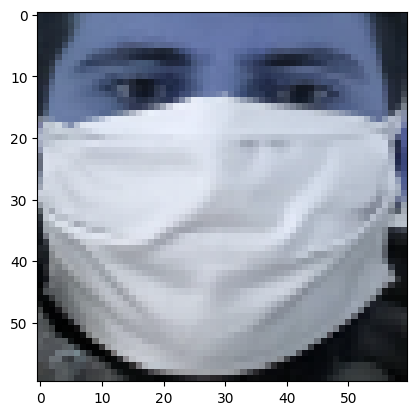

In [103]:
sample_mask_img = cv2.imread('/content/cropped_images/maksssksksss10-2104.png')
sample_mask_img = cv2.resize(sample_mask_img,(60,60))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,60,60,3])
sample_mask_img = sample_mask_img/255.0

In [104]:
model.predict(sample_mask_img)

1/1 [==============================] - 0s 169ms/step


array([[3.2580846e-03, 9.9674195e-01, 1.8225275e-10]], dtype=float32)

In [105]:
train_generator.class_indices


{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

The model is able to classify if the person is wearing a mask or not.

### image enhancement

In [106]:
from PIL import Image, ImageEnhance

def adjust_contrast(image, factor=1.5):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(factor)
    return enhanced_image


In [107]:
def adjust_brightness(image, factor=1.2):
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(factor)
    return enhanced_image


In [108]:
def sharpen_image(image, factor=2.0):
    enhancer = ImageEnhance.Sharpness(image)
    enhanced_image = enhancer.enhance(factor)
    return enhanced_image


In [109]:
import cv2

def histogram_equalization(image):
    img_y_cr_cb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    y_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
    enhanced_image = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCrCb2RGB)
    return enhanced_image


In [110]:
def apply_gaussian_blur(image, kernel_size=(5, 5)):
    enhanced_image = cv2.GaussianBlur(image, kernel_size, 0)
    return enhanced_image


In [111]:
def edge_detection(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    enhanced_image = cv2.Canny(gray_image, 100, 200)
    return enhanced_image


In [112]:
def enhance_color(image, factor=1.5):
    enhancer = ImageEnhance.Color(image)
    enhanced_image = enhancer.enhance(factor)
    return enhanced_image


In [113]:
def reduce_noise(image):
    enhanced_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return enhanced_image


#### Trying all 8

In [114]:
def preprocessing_function(img):
    # Apply various enhancements
    img = adjust_contrast(img)
    img = adjust_brightness(img)
    img = sharpen_image(img)
    img = histogram_equalization(img)
    img = apply_gaussian_blur(img)
    img = edge_detection(img)
    img = enhance_color(img)
    img = reduce_noise(img)

    return img


In [115]:
train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 64,
    seed = 42,
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)

val_image_generator = ImageDataGenerator(rescale = 1. / 255.)
val_generator = val_image_generator.flow_from_dataframe(
    dataframe = X_val,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,  # Shuffle the validation set if desired
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)


test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)

Found 3054 validated image filenames belonging to 3 classes.
Found 610 validated image filenames belonging to 3 classes.
Found 408 validated image filenames belonging to 3 classes.


In [116]:
# Display the model summary
model = make_model()
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_16 (Flatten)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [117]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision(), Recall()])

In [118]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Total number of batches in one epoch
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator)  # Total number of validation batches
)


Epoch 1/60
48/48 [==============================] - 3s 40ms/step - loss: 0.4281 - accuracy: 0.8386 - precision_1: 0.8498 - recall_1: 0.8229 - val_loss: 0.3615 - val_accuracy: 0.8574 - val_precision_1: 0.8679 - val_recall_1: 0.8508
Epoch 2/60
48/48 [==============================] - 2s 33ms/step - loss: 0.2989 - accuracy: 0.8897 - precision_1: 0.8965 - recall_1: 0.8847 - val_loss: 0.3383 - val_accuracy: 0.8672 - val_precision_1: 0.8696 - val_recall_1: 0.8639
Epoch 3/60
48/48 [==============================] - 2s 32ms/step - loss: 0.2670 - accuracy: 0.9021 - precision_1: 0.9060 - recall_1: 0.8965 - val_loss: 0.3379 - val_accuracy: 0.8656 - val_precision_1: 0.8692 - val_recall_1: 0.8607
Epoch 4/60
48/48 [==============================] - 2s 32ms/step - loss: 0.2446 - accuracy: 0.9086 - precision_1: 0.9145 - recall_1: 0.9031 - val_loss: 0.3335 - val_accuracy: 0.8607 - val_precision_1: 0.8649 - val_recall_1: 0.8607
Epoch 5/60
48/48 [==============================] - 2s 32ms/step - loss: 0.2

In [119]:
model.evaluate_generator(test_generator)

<ipython-input-119-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.4961717128753662,
 0.8995097875595093,
 0.8995097875595093,
 0.8995097875595093]

#### Trying  4

In [120]:
def preprocessing_function(img):
    # Apply various enhancements
    img = histogram_equalization(img)
    img = edge_detection(img)
    img = enhance_color(img)
    img = reduce_noise(img)

    return img


In [121]:
train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 64,
    seed = 42,
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)

val_image_generator = ImageDataGenerator(rescale = 1. / 255.)
val_generator = val_image_generator.flow_from_dataframe(
    dataframe = X_val,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,  # Shuffle the validation set if desired
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)


test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)

Found 3054 validated image filenames belonging to 3 classes.
Found 610 validated image filenames belonging to 3 classes.
Found 408 validated image filenames belonging to 3 classes.


In [122]:
# Display the model summary
model = make_model()
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_17 (Flatten)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [123]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision(), Recall()])

In [124]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Total number of batches in one epoch
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator)  # Total number of validation batches
)


Epoch 1/60
48/48 [==============================] - 3s 40ms/step - loss: 0.4720 - accuracy: 0.8294 - precision_2: 0.8334 - recall_2: 0.8209 - val_loss: 0.3579 - val_accuracy: 0.8557 - val_precision_2: 0.8607 - val_recall_2: 0.8508
Epoch 2/60
48/48 [==============================] - 2s 33ms/step - loss: 0.3043 - accuracy: 0.8877 - precision_2: 0.8941 - recall_2: 0.8818 - val_loss: 0.3300 - val_accuracy: 0.8656 - val_precision_2: 0.8735 - val_recall_2: 0.8607
Epoch 3/60
48/48 [==============================] - 2s 32ms/step - loss: 0.2737 - accuracy: 0.9021 - precision_2: 0.9090 - recall_2: 0.8965 - val_loss: 0.3406 - val_accuracy: 0.8689 - val_precision_2: 0.8733 - val_recall_2: 0.8590
Epoch 4/60
48/48 [==============================] - 2s 33ms/step - loss: 0.2554 - accuracy: 0.9054 - precision_2: 0.9105 - recall_2: 0.8995 - val_loss: 0.3604 - val_accuracy: 0.8639 - val_precision_2: 0.8690 - val_recall_2: 0.8590
Epoch 5/60
48/48 [==============================] - 2s 34ms/step - loss: 0.2

In [125]:
model.evaluate_generator(test_generator)

<ipython-input-125-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.5484808087348938,
 0.9093137383460999,
 0.9093137383460999,
 0.9093137383460999]

#### Trying 2

In [126]:
def preprocessing_function(img):
    # Apply various enhancements
    img = histogram_equalization(img)
    img = reduce_noise(img)

    return img


In [127]:
train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 64,
    seed = 42,
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)

val_image_generator = ImageDataGenerator(rescale = 1. / 255.)
val_generator = val_image_generator.flow_from_dataframe(
    dataframe = X_val,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,  # Shuffle the validation set if desired
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)


test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = '/content/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 64,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size,
    preprocessing_function = preprocessing_function
)

Found 3054 validated image filenames belonging to 3 classes.
Found 610 validated image filenames belonging to 3 classes.
Found 408 validated image filenames belonging to 3 classes.


In [128]:
# Display the model summary
model = make_model()
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_18 (Flatten)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dense_33 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [129]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision(), Recall()])

In [130]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Total number of batches in one epoch
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator)  # Total number of validation batches
)


Epoch 1/60
48/48 [==============================] - 3s 39ms/step - loss: 0.4356 - accuracy: 0.8484 - precision_3: 0.8509 - recall_3: 0.8392 - val_loss: 0.3837 - val_accuracy: 0.8525 - val_precision_3: 0.8610 - val_recall_3: 0.8426
Epoch 2/60
48/48 [==============================] - 2s 32ms/step - loss: 0.3040 - accuracy: 0.8870 - precision_3: 0.8924 - recall_3: 0.8798 - val_loss: 0.3294 - val_accuracy: 0.8721 - val_precision_3: 0.8754 - val_recall_3: 0.8639
Epoch 3/60
48/48 [==============================] - 2s 33ms/step - loss: 0.2674 - accuracy: 0.9001 - precision_3: 0.9074 - recall_3: 0.8955 - val_loss: 0.3296 - val_accuracy: 0.8721 - val_precision_3: 0.8791 - val_recall_3: 0.8705
Epoch 4/60
48/48 [==============================] - 2s 32ms/step - loss: 0.2502 - accuracy: 0.9116 - precision_3: 0.9159 - recall_3: 0.9057 - val_loss: 0.3241 - val_accuracy: 0.8738 - val_precision_3: 0.8821 - val_recall_3: 0.8705
Epoch 5/60
48/48 [==============================] - 2s 32ms/step - loss: 0.2

In [131]:
model.evaluate_generator(test_generator)

<ipython-input-131-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.49192970991134644, 0.906862735748291, 0.906862735748291, 0.906862735748291]

### Save the model.

In [137]:
model.save('faceDetectionModel.h5')

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


X, y = np.array([...]), np.array([...])  # Your data here

# Define KFold cross-validator
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# K-Fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(X):
    # Split data
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Define your model here
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision(), Recall()])
    # Fit the model
    print(f'Training for fold {fold_no}...')
    model.fit(X_train, Y_train, epochs=30, batch_size=32)

    # Evaluate the model
    scores = model.evaluate(X_test, Y_test)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    # Increase fold number
    fold_no += 1
